# WDSR

In [1]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.wdsr import wdsr_b
from train import WdsrTrainer

%matplotlib inline

In [2]:
# Number of residual blocks
depth = 32

# Super-resolution factor
scale = 4

# Downgrade operator
downgrade = 'bicubic'

In [3]:
# Location of model weights (needed for demo)
weights_dir = f'weights/wdsr-b-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [ ]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [ ]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-32-x4.tar.gz](https://drive.google.com/open?id=1JfQNGQZ9cG-lyC5EB0W3MpySjPlDJXpU) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-32-x4` directory containing the weights of the pre-trained model.

In [ ]:
trainer = WdsrTrainer(model=wdsr_b(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/wdsr-b-{depth}-x{scale}')

In [ ]:
# Train WDSR B model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
trainer.train(train_ds,
              valid_ds.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

In [ ]:
# Restore from checkpoint with highest PSNR
trainer.restore()

In [ ]:
# Evaluate model on full validation set
psnr = trainer.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

In [ ]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Demo

In [4]:
model = wdsr_b(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [5]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

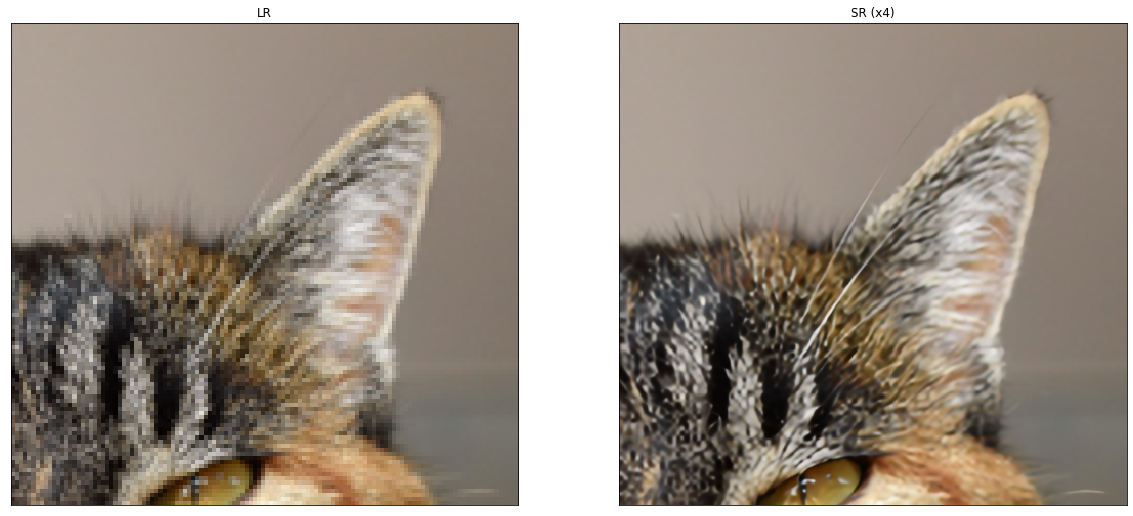

In [6]:
resolve_and_plot('demo/0869x4-crop.png')

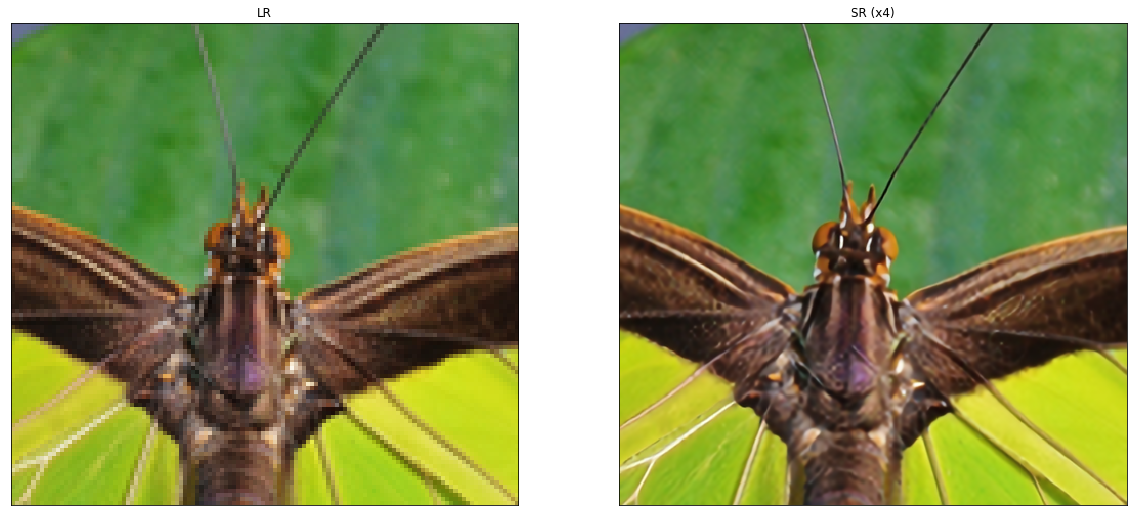

In [7]:
resolve_and_plot('demo/0829x4-crop.png')

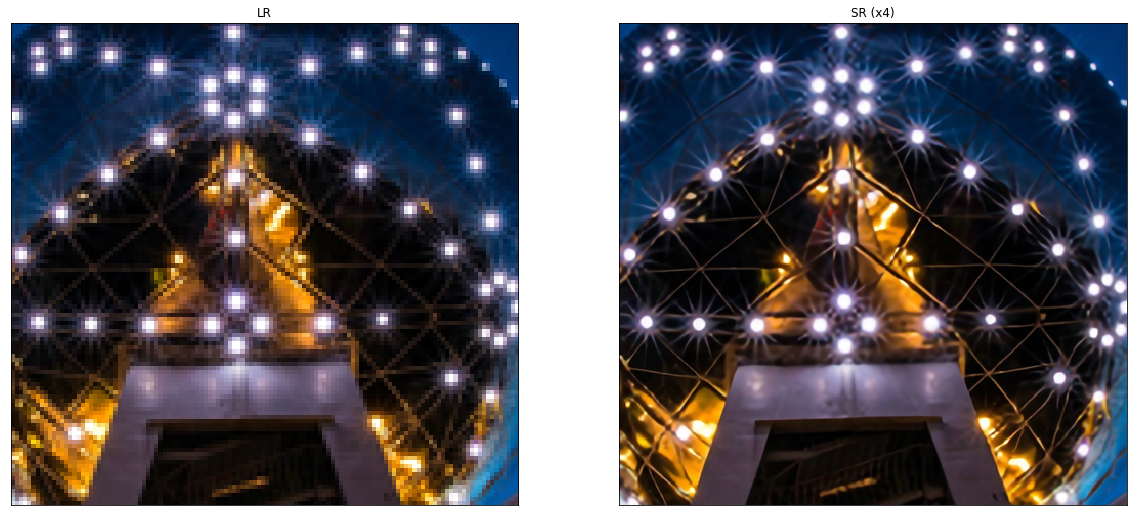

In [8]:
resolve_and_plot('demo/0851x4-crop.png')

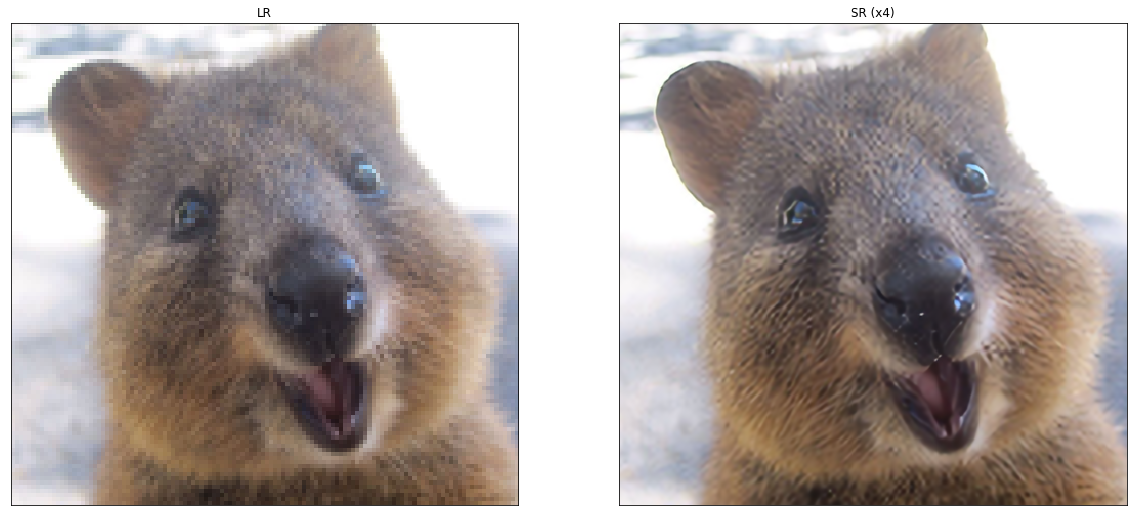

In [9]:
resolve_and_plot('demo/quokka.png')

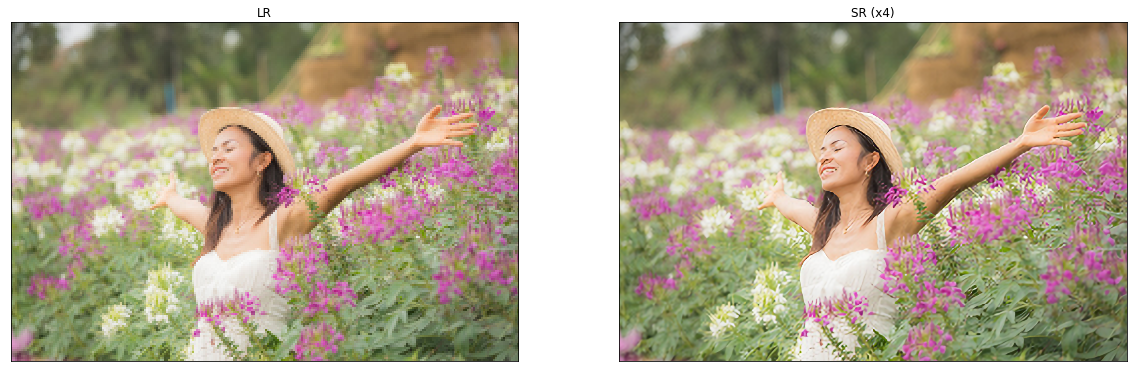

In [10]:
resolve_and_plot('demo/flowers.png')